In [ ]:
from functions import *
from inverse_RTI import inverse_RTI_algo


parameters = {}

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40  # dB

# imaging parameters
parameters['doi_size'] = 3
parameters['alpha'] = 1e2  # 1e2
parameters['grid_resolution'] = 0.1
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']))

parameters['eterm'] = 1

signal = generate_signal()

devices = init_devices(parameters)

In [ ]:
# counter = 0
# while True:
#     counter += 1
#     np.save(f'result/{counter}.npy', data_collection_once(parameters, signal, devices))
#     print(counter)
#     # time.sleep(10)
#     input("Press Enter to continue...")



<function matplotlib.pyplot.show(close=None, block=None)>

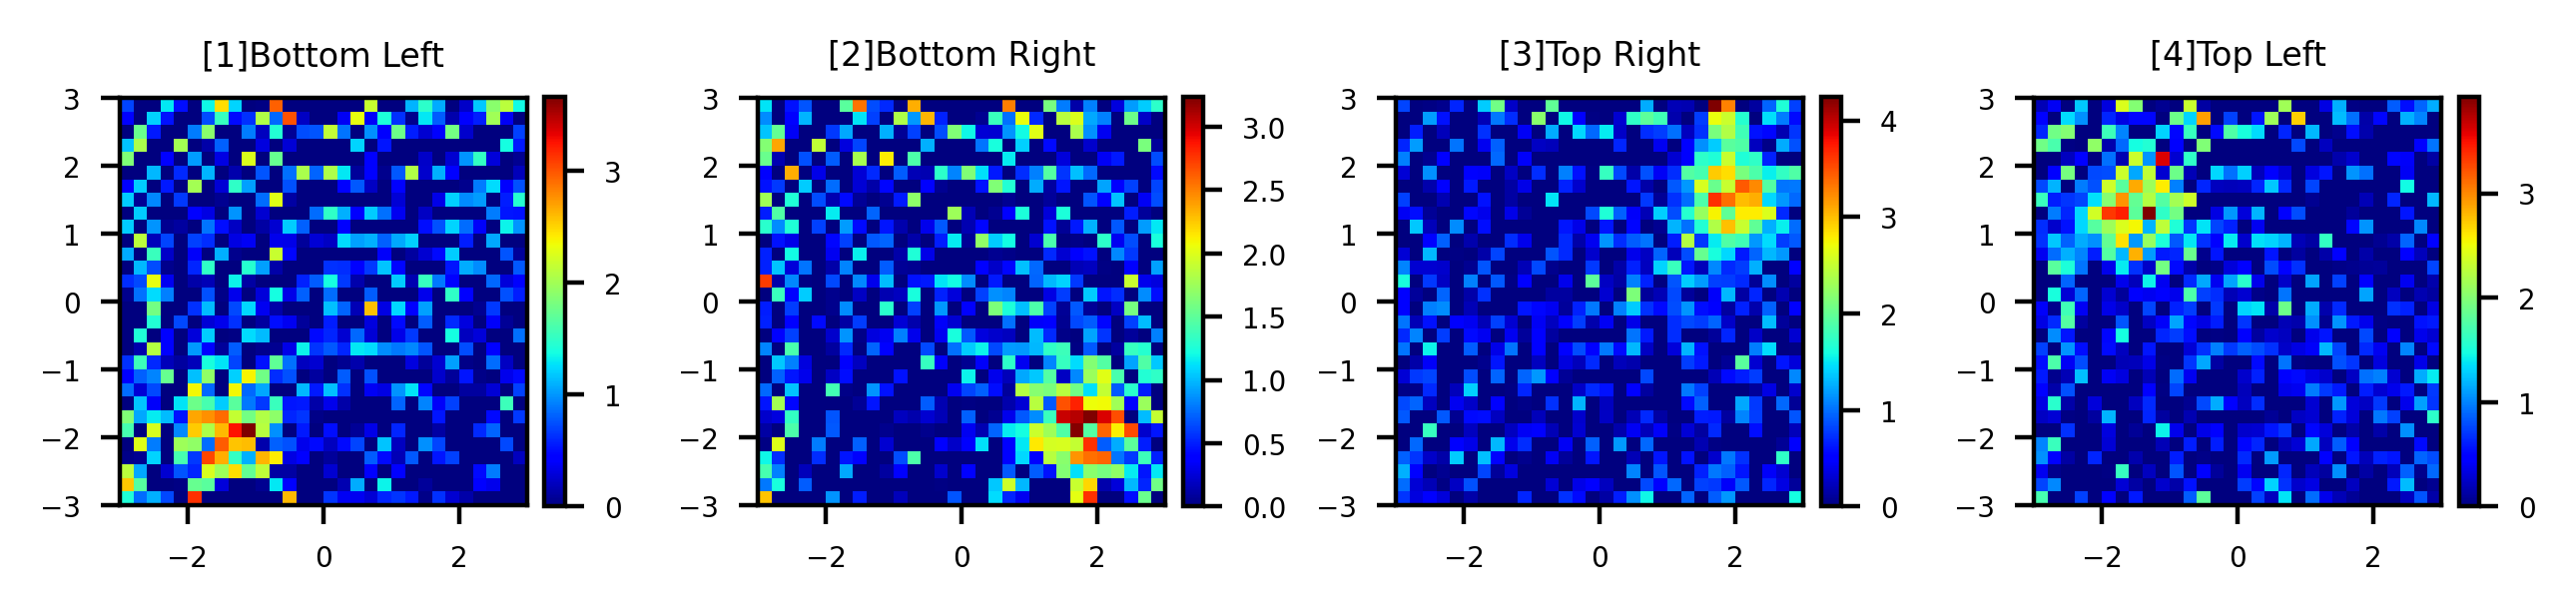

In [36]:
from functions import *
from inverse_RTI import *
from xPRA import *


parameters = {}

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40  # dBsim_result
parameters['wavelength'] = 3e8/parameters['center_freq']


# imaging parameters
parameters['doi_size'] = 1.5
parameters['alpha'] = 0.5  # 1e2
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']))

parameters['eterm'] = 1
parameters['k0'] = 2*np.pi/parameters['wavelength']
parameters['cellrad'] = (np.sqrt(parameters['grid_resolution']**2/np.pi)*2)/2


signal = generate_signal()

# devices = init_devices(parameters)

FrytB = xPRA_preparation(parameters)

    
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

import pathlib
import scipy.io

path = 'result'
test_files = sorted(list(pathlib.Path(path).glob('*.npy')))
plt.rcParams.update({'font.size': 5})

Pinc = np.load(test_files.pop(0))
Pinc= magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0], dtype=bool)].reshape(-1, 1)
scipy.io.savemat(path+'/Pinc.mat', {'Pinc': Pinc.reshape((19, 20), order='F')})


fig, axs = plt.subplots(1, len(test_files))
sub_titles = ['Bottom Left', 'Bottom Right', 'Top Right','Top Left']
fig.subplots_adjust(hspace=0.3)

for i, Ptot in enumerate(test_files):
    Ptot = np.load(Ptot)
    Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
    Ptot = Ptot[~np.eye(Ptot.shape[0], dtype=bool)].reshape(-1, 1)
    scipy.io.savemat(path+f'/Ptot{i+1}.mat', {'Ptot': Ptot.reshape((19, 20), order='F')})
    
    xPRA_result = xPRA(parameters, Pinc, Ptot)

    im = axs[i].imshow(xPRA_result, extent=[-3, 3, -3, 3], cmap='jet')
    axs[i].set_title(f'[{i+1}]{sub_titles[i]}')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show